# Кластеризация отзывов

In [33]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [34]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
# Функция для удаления ненужных символов текста
def clean_text_regex(text):
    text = re.sub(r'\n', ' ', text)
    cleaned = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
    return cleaned.lower()

In [36]:
# Функция для лемматизации и удаления стоп-слов
import pymorphy2
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    developer_stop_words = stop_words.union({'читать', 'далее', 'всё', 'это', 'жк', 'квартира', 'дом', 'дома',
                                            'рядом', 'очень', 'ещё', 'квартиры', 'квартиру', 'пока', 'просто', 'отличный', 'хороший',
                                             'пик', 'лср', 'место', 'застройщик', 'комплекс', 'проект', 'вид',
                                            'окна', 'квартир', 'район', 'жилой', 'застройщика',
                                             'жить', 'будут', 'строительства', 'целом', 'купили', 'люди',
                                             'который', 'такой'
                                            })
    tokens = [word for word in tokens if word not in developer_stop_words]
    morph = pymorphy2.MorphAnalyzer()
    tokens = [morph.parse(word)[0].normal_form for word in tokens if morph.parse(word)[0].normal_form not in developer_stop_words]
    return ' '.join(tokens)

In [37]:
# Чтение файла с отзывами
data = pd.read_csv('reviews11.csv')

In [38]:
# Для удобства переименовываем колонку
data.rename(columns={'Отзыв': 'review'}, inplace=True)
# Применяем функции для предобработки текста
data['review_cleaned'] = data['review'].apply(lambda x: preprocess_text(clean_text_regex(x)))

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизуем текст
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=7,
    max_df=0.9,
    ngram_range=(1, 2)
)

X_tfidf = tfidf_vectorizer.fit_transform(data['review_cleaned'])

In [40]:
import umap

reducer = umap.UMAP(n_components=50, metric='cosine', n_neighbors=10, random_state=42)
X_reduced = reducer.fit_transform(X_tfidf)

C:\Users\elytk\.conda\envs\data_ml\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Кластеров: 3, Silhouette Score: 0.181
Кластеров: 4, Silhouette Score: 0.182
Кластеров: 5, Silhouette Score: 0.167
Кластеров: 6, Silhouette Score: 0.179
Кластеров: 7, Silhouette Score: 0.176


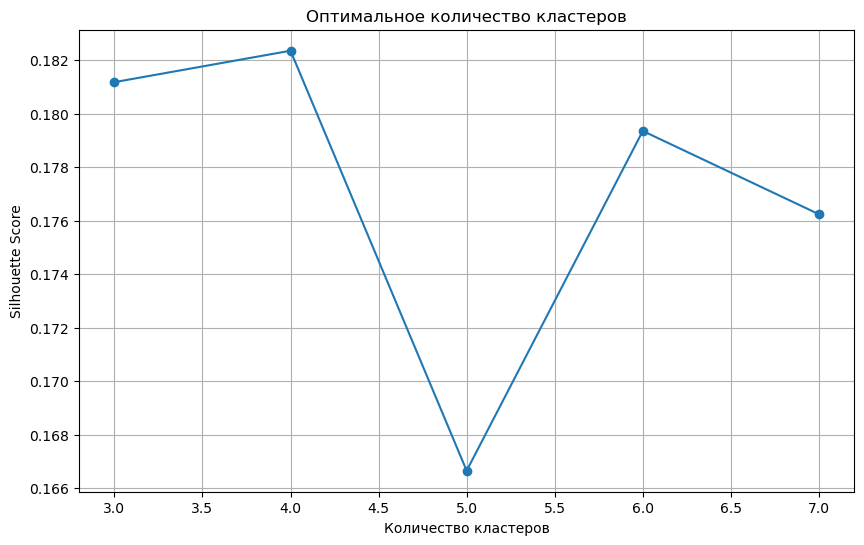

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Производим подбор количества кластеров с помощью подсчета метрики
for n_clusters in range(3, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(score)
    print(f"Кластеров: {n_clusters}, Silhouette Score: {score:.3f}")
    
# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(3, 8), silhouette_scores, marker='o')
plt.grid(True)
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Оптимальное количество кластеров')
plt.show()
    
optimal_n = np.argmax(silhouette_scores) + 3

# Обучаем K-Means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_n, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_reduced)

In [42]:
# Функция для извлечения топа слов
def extract_key_themes(df, n_keywords=10):
    from sklearn.feature_extraction.text import CountVectorizer
    
    themes_by_cluster = {}
    
    for cluster_id in df['cluster'].unique():
        cluster_texts = df[df['cluster'] == cluster_id]['review_cleaned'].tolist()
        # Используем CountVectorizer для частотного анализа
        cv = CountVectorizer(max_features=100, ngram_range=(1, 3))
        cv_matrix = cv.fit_transform(cluster_texts)
        # Получаем частоты слов
        word_counts = cv_matrix.sum(axis=0)
        words_freq = [(word, word_counts[0, idx]) 
                     for word, idx in cv.vocabulary_.items()]
        # Сортируем по частоте
        words_freq.sort(key=lambda x: x[1], reverse=True)
        # Берем топ слов
        top_keywords = [word for word, freq in words_freq[:n_keywords]]
        themes_by_cluster[cluster_id] = top_keywords
    return themes_by_cluster

# Извлекаем ключевые темы
themes = extract_key_themes(data, n_keywords=10)
print("\nКлючевые темы по кластерам:")
for cluster_id, keywords in themes.items():
    print(f"Кластер {cluster_id}: {', '.join(keywords)}")


Ключевые темы по кластерам:
Кластер 3: детский, школа, площадка, двор, сад, магазин, детский площадка, закрытый, красивый, территория
Кластер 0: год, первый, этаж, класс, номер, двор, бизнес, цена, день, качество
Кластер 2: красивый, новый, цена, инфраструктура, локация, планировка, современный, уютный, город, свой
Кластер 1: дорога, город, минута, машина, пробка, метро, школа, доступность, инфраструктура, транспортный


In [43]:
# Количество объектов в кластерах
data['cluster'].value_counts()

cluster
2    1219
0     772
1     557
3     522
Name: count, dtype: int64

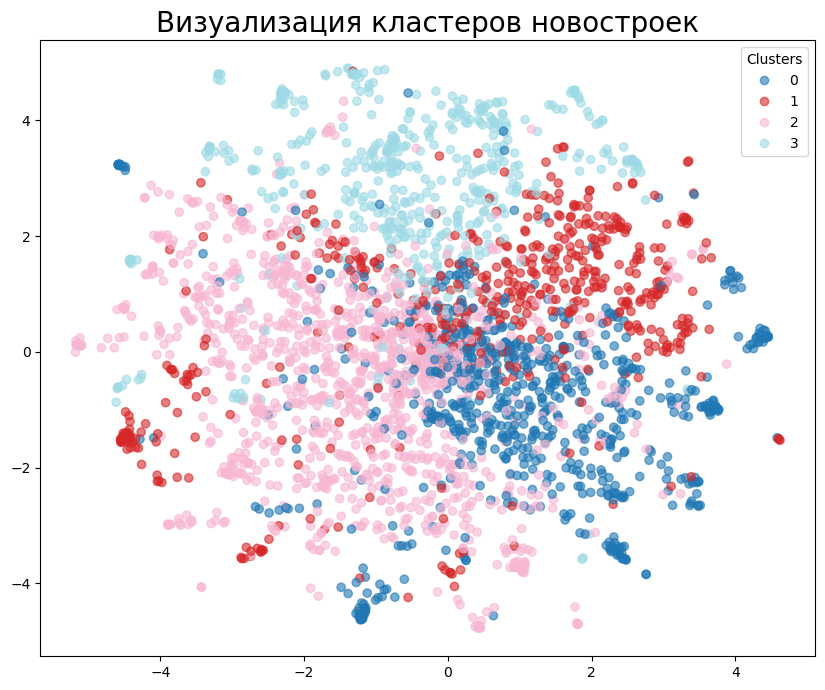

In [44]:
# Визуализация кластеров (TSNE лучше визуализирует, чем PCA)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, init='random')
features_2d = tsne.fit_transform(X_tfidf)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=data['cluster'], cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Визуализация кластеров новостроек', fontsize=20)
plt.savefig('claster.png')

C:\Users\elytk\.conda\envs\data_ml\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


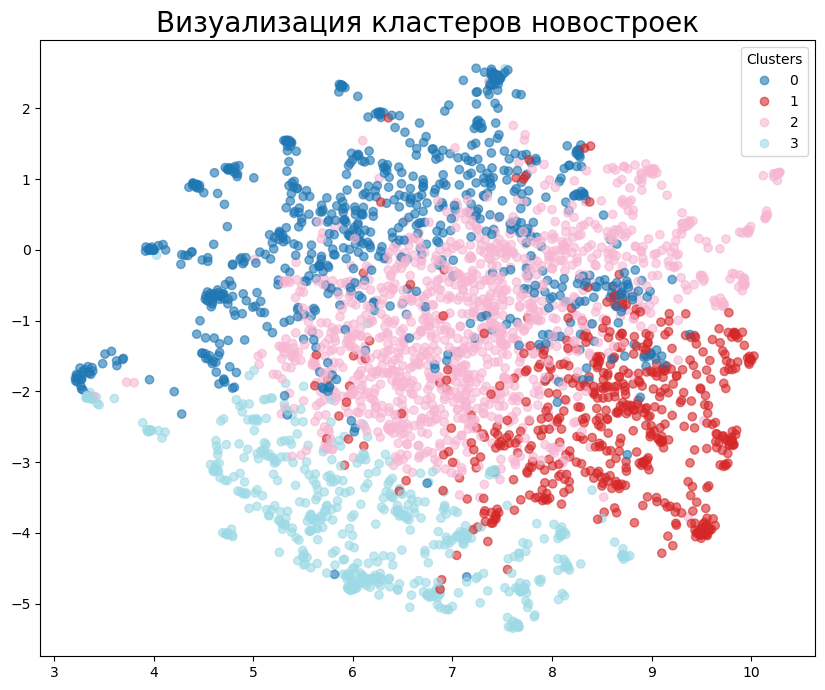

In [45]:
import umap

# Визуализация кластеров (TSNE лучше визуализирует, чем PCA)
from sklearn.manifold import TSNE

u = umap.UMAP(n_components=2, metric='cosine', random_state=42)
features_2d = u.fit_transform(X_tfidf)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=data['cluster'], cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Визуализация кластеров новостроек', fontsize=20)
plt.savefig('claster_tsne.png')

# Кластеризация новостроек

In [46]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [47]:
# Считываем файл и удаляем NaN в важных столбцах
data = pd.read_csv('buildings.csv')
data.dropna(subset=['min_metro'], inplace=True)
data.dropna(subset=['total_area'], inplace=True)
data.dropna(subset=['rooms'], inplace=True)
# Создаем столбец с "относительным" этажом
data['is_city'] = data['is_city'].astype(int)
data['court'] = data['court'].astype(int)
data['entrance'] = data['entrance'].astype(int)
data['parking'] = data['parking'].astype(int)
data['parks'] = data['parks'].astype(int)
data['floor_perc'] = round(data['floor_current'] * 100 / data['floor_total'])
data['description'] = data['description'].fillna('')

In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Стандартизация числовых признаков
numeric_features = ['floor_perc', 'min_metro', 'total_area', 'is_city', 'court', 'entrance', 'parking', 'parks']
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(data[numeric_features])

# Кодирование категориальных признаков
categorical_features = ['rooms', 'hc_class']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(data[categorical_features])

In [49]:
import numpy as np
from scipy.sparse import csr_matrix, hstack

numeric_sparse = csr_matrix(numeric_scaled)
categorical_sparse = csr_matrix(categorical_encoded)

# Теперь объединяем
all_features = hstack([numeric_sparse, categorical_sparse])

Кластеров: 2, Silhouette Score: 0.223
Кластеров: 3, Silhouette Score: 0.213
Кластеров: 4, Silhouette Score: 0.225
Кластеров: 5, Silhouette Score: 0.227
Кластеров: 6, Silhouette Score: 0.227
Кластеров: 7, Silhouette Score: 0.237


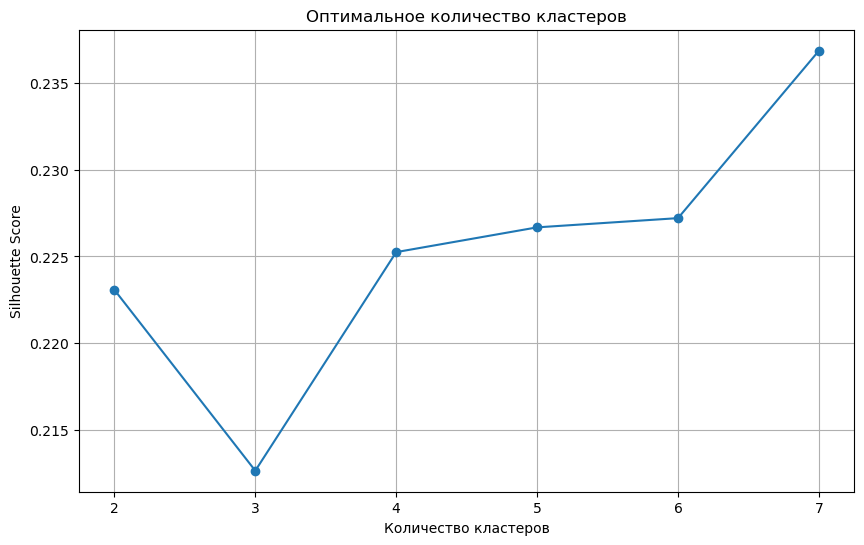

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Производим подбор количества кластеров с помощью подсчета метрики
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(all_features)
    score = silhouette_score(all_features, cluster_labels)
    silhouette_scores.append(score)
    print(f"Кластеров: {n_clusters}, Silhouette Score: {score:.3f}")
    
# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(range(2, 8), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Оптимальное количество кластеров')
plt.show()
    
optimal_n = np.argmax(silhouette_scores) + 2

# Обучаем K-Means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_n, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(all_features)

In [51]:
data['cluster'].value_counts()

cluster
2    317
3    302
6    207
4    182
5    156
1    141
0     67
Name: count, dtype: int64

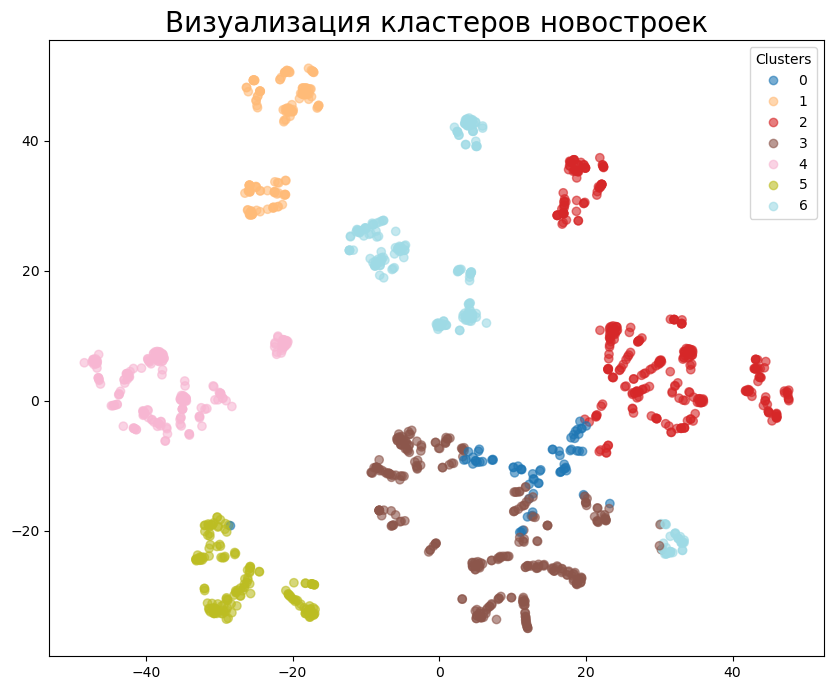

In [52]:
# Анализ характеристик кластеров
cluster_stats = data.groupby('cluster').agg({
    'total_area': [('mean', lambda x: round(x.mean(), 2))],
    'min_metro': [('mean', lambda x: round(x.mean(), 2))],
    'rooms': lambda x: x.mode()[0] if not x.mode().empty else None,
    'floor_perc': [('mean', lambda x: round(x.mean(), 2))],
    'hc_class': lambda x: x.mode()[0] if not x.mode().empty else None,
    'is_city': lambda x: x.mode()[0] if not x.mode().empty else None,
    'court': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'entrance': lambda x: x.mode()[0] if not x.mode().empty else None,
    'parking': lambda x: x.mode()[0] if not x.mode().empty else None,
    'parks': lambda x: x.mode()[0] if not x.mode().empty else None
})

# Визуализация кластеров
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=data['cluster'], cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Визуализация кластеров новостроек', fontsize=20)
plt.savefig('claster2.png')

In [53]:
cluster_stats

,total_area,min_metro,rooms,floor_perc,hc_class,is_city,court,entrance,parking,parks
,mean,mean,<lambda>,mean,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>
cluster,,,,,,,,,,
0,133.21,6.52,3.0,64.18,Премиум,1,1,1,1,0
1,54.08,17.84,2.0,42.23,Комфорт,0,1,0,1,0
2,40.33,9.32,1.0,42.03,Комфорт,1,1,1,1,1
3,39.07,6.36,1.0,42.82,Бизнес,1,1,1,1,0
4,51.05,17.63,1.0,40.02,Комфорт,0,0,0,0,0
5,49.88,5.94,1.0,34.29,Комфорт,1,0,0,0,0
6,45.27,14.96,1.0,40.55,Комфорт,0,1,1,0,0


In [54]:
cluster_stats.columns = ['площадь', 'минуты до метро', 'количество комнат', 
                         'относительный этаж', 'класс', 'город ли это', 'есть ли внутренний двор', 
                         'есть ли входная группа', 'есть ли паркинг', 'есть ли парки']

In [55]:
cluster_stats

,площадь,минуты до метро,количество комнат,относительный этаж,класс,город ли это,есть ли внутренний двор,есть ли входная группа,есть ли паркинг,есть ли парки
cluster,,,,,,,,,,
0,133.21,6.52,3.0,64.18,Премиум,1,1,1,1,0
1,54.08,17.84,2.0,42.23,Комфорт,0,1,0,1,0
2,40.33,9.32,1.0,42.03,Комфорт,1,1,1,1,1
3,39.07,6.36,1.0,42.82,Бизнес,1,1,1,1,0
4,51.05,17.63,1.0,40.02,Комфорт,0,0,0,0,0
5,49.88,5.94,1.0,34.29,Комфорт,1,0,0,0,0
6,45.27,14.96,1.0,40.55,Комфорт,0,1,1,0,0


# Присваивание классов квартирам

In [56]:
import pandas as pd
import numpy as np

In [57]:
# Загрузка данных
df = pd.read_csv('buildings.csv')

# Создаем копию для работы
df = df.copy()

In [58]:
# Функция классификации
def classify_apartment(row):
    # Извлекаем признаки
    rooms = row.get('rooms', 0)
    hc_class = str(row.get('hc_class', '')).lower() if pd.notna(row.get('hc_class')) else ''
    min_metro = row.get('min_metro')
    price_per_m2 = row.get('price_per_m2', 0)
    elevators = row.get('elevators', 0) if pd.notna(row.get('hc_class')) else 0
    # Получаем общее количество этажей
    floor_total = row.get('floor_total', 1)
    
    # Цена за м2 (определяем квартили)
    price_q1 = df['price_per_m2'].quantile(0.25)
    price_q2 = df['price_per_m2'].quantile(0.50)
    price_q3 = df['price_per_m2'].quantile(0.75)
    
    # Дополнительные признаки
    description = str(row.get('description', '')).lower()
    is_available = row.get('available', False)
    
    # Ключевые слова в описании для каждого кластера
    has_children_words = any(word in description for word in [
        'детск', 'школ', 'сад', 'площадк', 'безопасн', 'закрыт', 'двор', 'парк'
    ])
    
    has_business_words = any(word in description for word in [
        'коммерц', 'качеств'
    ])
    
    has_cozy_words = any(word in description for word in [
        'современн', 'уют', 'атмосфер', 'домашн'
    ])
    
    has_transport_words = any(word in description for word in [
        'доступн', 'транспорт', 'метро', 'машин', 'дорог', 'пробк'
    ])
    
    # Логика классификации
    
    # Кластер 3: «Детский»
    if (rooms in [2, 3, 4]) and (hc_class in ['бизнес', 'комфорт'] or has_children_words):
        confirmations = 0
        if has_children_words:
            confirmations += 2
        if price_per_m2 < price_q3:
            confirmations += 2
            
        if confirmations >= 2:
            return 3
    
    # Кластер 0: «Бюджетный бизнес-класс»
    if (hc_class in ['бизнес', 'комфорт']) and (price_q1 < price_per_m2 < price_q3):
        confirmations = 0
        if min_metro <= 10:
            confirmations += 1
        if has_business_words:
            confirmations += 2  # Важно для района
        if confirmations >= 1:
            return 0
    
    # Кластер 1: «Транспортная доступность»
    if min_metro <= 8 and (hc_class in ['бизнес', 'комфорт']):
        confirmations = 0
        if has_transport_words:
            confirmations += 2
        if price_per_m2 < price_q3:
            confirmations += 1
        if rooms in [0, 1]:
            confirmations += 1
        if confirmations >= 2:
            return 1
    
    # Кластер 2: «Современный уют»
    if hc_class in ['бизнес', 'премиум']:
        confirmations = 0
        if has_cozy_words:
            confirmations += 2
        if price_per_m2 > price_q3:
            confirmations += 1
        if rooms in [0, 1]:
            confirmations += 1
        if confirmations >= 1:
            return 2
    
    # Резервная логика по основным правилам
    # Приоритет 1: По количеству комнат
    if rooms in [0, 1]:
        return 1 
    
    elif rooms in [1, 2]:
        if hc_class == 'премиум':
            return 2 
        else:
            return 0
    
    elif rooms in [2, 3, 4]:
        return 3
    
    
    # Приоритет 4: По цене
    if price_per_m2 <= price_q1:
        return 1
    elif price_per_m2 <= price_q2:
        return 0
    elif price_per_m2 <= price_q3:
        return 3
    elif price_per_m2 >= price_q3:
        return 2
    
    # По умолчанию
    return 3

In [59]:
# Применяем классификацию
df['cluster'] = df.apply(classify_apartment, axis=1)

# Сохраняем результат
df.to_csv('buildings_classified.csv', index=False, encoding='utf-8-sig')

cluster_stats = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_stats.items():
    percentage = (count / len(df)) * 100
    print(f"Кластер {cluster_id}: {count} объектов ({percentage:.1f}%)")

Кластер 0: 314 объектов (22.1%)
Кластер 1: 465 объектов (32.8%)
Кластер 2: 130 объектов (9.2%)
Кластер 3: 510 объектов (35.9%)


# Анализ результатов

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

In [61]:
# Загрузка данных
df = pd.read_csv('buildings_classified.csv')
df['ready'] = pd.to_numeric(df['ready'], errors='coerce').fillna(0).astype(bool)
df['log_price_per_sqm'] = np.log(df['price_per_m2'])
df['floor_perc'] = df['floor_current'] / df['floor_total']

# Преобразование булевых признаков
names_bool = ['ready', 'is_city', 'popular_developer', 'court', 'entrance', 'parking', 'parks']
for name in names_bool:
    df[name] = pd.to_numeric(df[name], errors='coerce').fillna(0).astype(int)

df.dropna(subset=['total_area', 'floor_perc', 'log_price_per_sqm'], inplace=True)

# Определение признаков
numeric_features = ['floor_perc', 'total_area']
bool_features = ['is_city', 'ready', 'popular_developer', 'court', 'entrance', 'parking', 'parks']
all_feature_names = numeric_features + bool_features

# Подготовка данных
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_features])
X = np.hstack([numeric_scaled, df[bool_features].values])
y = df['log_price_per_sqm'].values

In [62]:
# Анализ по кластерам
df_analysis = df.copy()
cluster_models = {}
cluster_predictions = {}
    
for cluster_id in sorted(df['cluster'].unique()):
    print(f"Анализ для кластера {cluster_id}:")
        
    cluster_mask = df['cluster'] == cluster_id
    X_cluster = X[cluster_mask]
    y_cluster = y[cluster_mask]
        
    # Обучение модели кластера
    lasso_cluster = LassoCV(
        cv=min(5, len(y_cluster)//3), 
        max_iter=10000, 
        random_state=42,
        n_alphas=20
    )
    lasso_cluster.fit(X_cluster, y_cluster)
    cluster_models[cluster_id] = lasso_cluster
            
    # Предсказания и JTBD score
    y_pred_cluster = lasso_cluster.predict(X_cluster)
    mae = np.abs(y_cluster - y_pred_cluster)
    jtbd_score = 100 * (1 - (mae / (mae.max() if mae.max() > 0 else 1)))
            
    # Сохранение предсказаний
    cluster_indices = df_analysis[cluster_mask].index
    for idx, jtbd, pred_price in zip(cluster_indices, jtbd_score, y_pred_cluster):
        cluster_predictions[idx] = {
            'cluster': cluster_id,
            'jtbd_score': jtbd,
            'pred_log_price': pred_price,
            'actual_log_price': y[df_analysis.index.get_loc(idx)]
        }
            
    # Анализ коэффициентов
    coef_cluster_df = pd.DataFrame({
        'feature': all_feature_names,
        'coefficient': lasso_cluster.coef_,
        'premium_percent': np.exp(lasso_cluster.coef_) - 1
    })
    non_zero_coefs = coef_cluster_df[coef_cluster_df['coefficient'] != 0]
            
    if not non_zero_coefs.empty:
        non_zero_coefs = non_zero_coefs.sort_values('coefficient', ascending=False)
        print(f"Важные признаки для кластера {cluster_id}:")
        print(non_zero_coefs)
        print(f"R² для кластера: {lasso_cluster.score(X_cluster, y_cluster):.4f}")
    else:
        print(f"Все коэффициенты равны нулю")

Анализ для кластера 0:
Важные признаки для кластера 0:
      feature  coefficient  premium_percent
2     is_city     0.107019         0.112955
6    entrance     0.074192         0.077014
7     parking    -0.000005        -0.000005
8       parks    -0.012107        -0.012034
1  total_area    -0.187243        -0.170758
R² для кластера: 0.4175
Анализ для кластера 1:
Важные признаки для кластера 1:
      feature  coefficient  premium_percent
2     is_city     0.288329         0.334197
6    entrance     0.059086         0.060866
0  floor_perc     0.036747         0.037431
7     parking    -0.084979        -0.081468
3       ready    -0.142864        -0.133128
1  total_area    -0.485678        -0.384720
R² для кластера: 0.5484
Анализ для кластера 2:
Важные признаки для кластера 2:
      feature  coefficient  premium_percent
2     is_city     0.415917         0.515760
6    entrance     0.121399         0.129075
0  floor_perc     0.093000         0.097462
1  total_area     0.053703         0.05

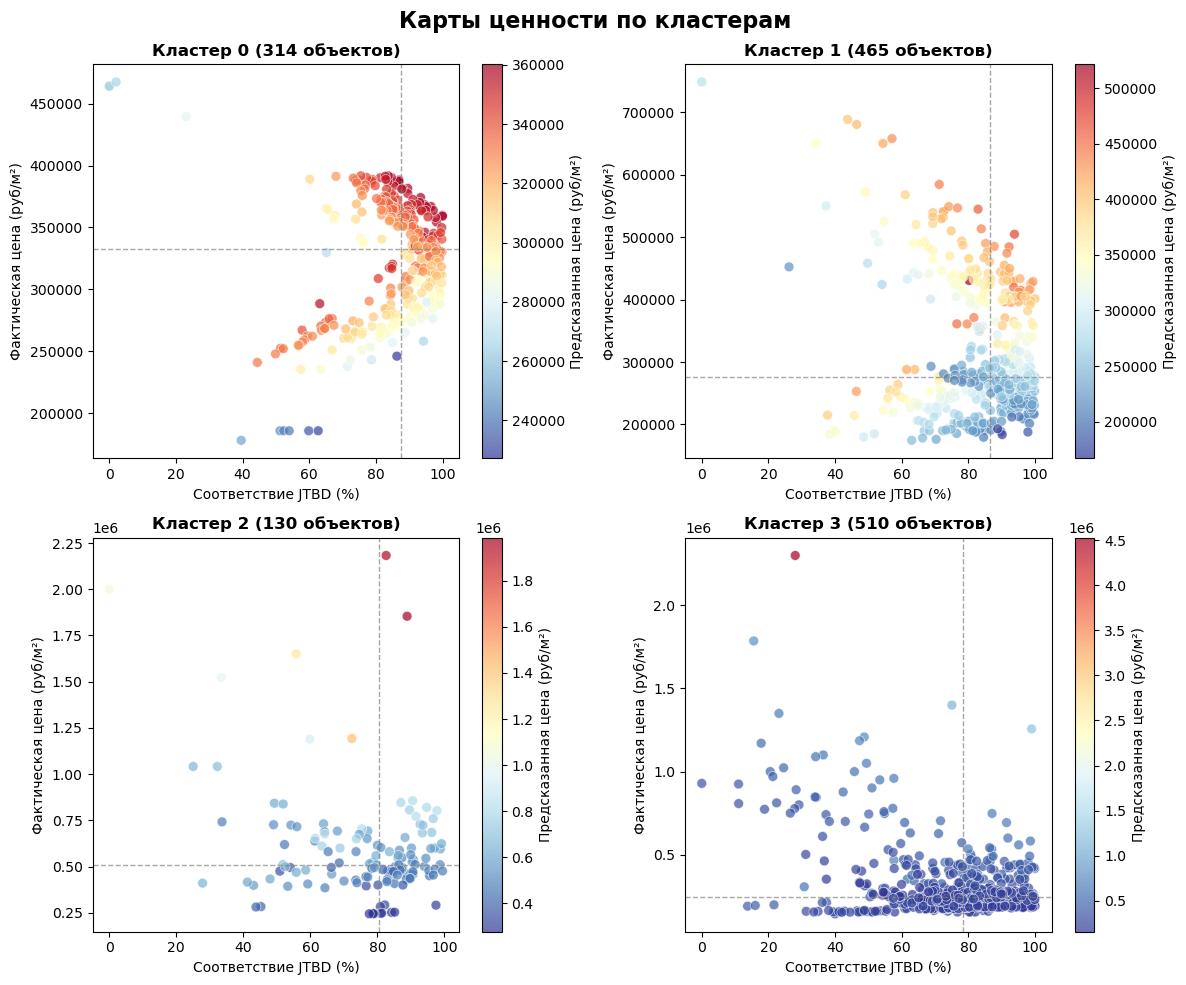

In [68]:
# Добавление предсказаний в DataFrame
df_analysis['jtbd_score'] = np.nan
df_analysis['pred_log_price'] = np.nan
        
for idx, pred_data in cluster_predictions.items():
    if idx in df_analysis.index:
        df_analysis.at[idx, 'jtbd_score'] = pred_data['jtbd_score']
        df_analysis.at[idx, 'pred_log_price'] = pred_data['pred_log_price']
        
# Очистка и преобразование данных
df_analysis_clean = df_analysis.dropna(subset=['jtbd_score', 'pred_log_price', 'price_per_m2'])
df_analysis_clean['pred_price_per_m2'] = np.exp(df_analysis_clean['pred_log_price'])
        
clusters_to_plot = sorted(df_analysis_clean['cluster'].unique())
        
if clusters_to_plot:
    # Общий график
    n_clusters = len(clusters_to_plot)
    n_cols = min(2, n_clusters)
    n_rows = (n_clusters + n_cols - 1) // n_cols
            
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    fig.suptitle('Карты ценности по кластерам', fontsize=16, fontweight='bold')
            
    for idx, cluster_id in enumerate(clusters_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
                
        cluster_data = df_analysis_clean[df_analysis_clean['cluster'] == cluster_id]
                
        median_jtbd = cluster_data['jtbd_score'].median()
        median_price = cluster_data['price_per_m2'].median()
                    
        scatter = ax.scatter(
            cluster_data['jtbd_score'],
            cluster_data['price_per_m2'],
            c=cluster_data['pred_price_per_m2'],
            cmap='RdYlBu_r',
            alpha=0.7,
                s=50,
                edgecolors='w',
                linewidth=0.5
            )
                    
        plt.colorbar(scatter, ax=ax, label='Предсказанная цена (руб/м²)')
                    
        ax.axhline(y=median_price, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=median_jtbd, color='gray', linestyle='--', alpha=0.7, linewidth=1)
                    
        ax.set_xlabel('Соответствие JTBD (%)', fontsize=10)
        ax.set_ylabel('Фактическая цена (руб/м²)', fontsize=10)
        ax.set_title(f'Кластер {cluster_id} ({len(cluster_data)} объектов)', fontsize=12, fontweight='bold')
            
plt.tight_layout()
plt.savefig(f'clusters_all.png', dpi=300, bbox_inches='tight')
plt.show()

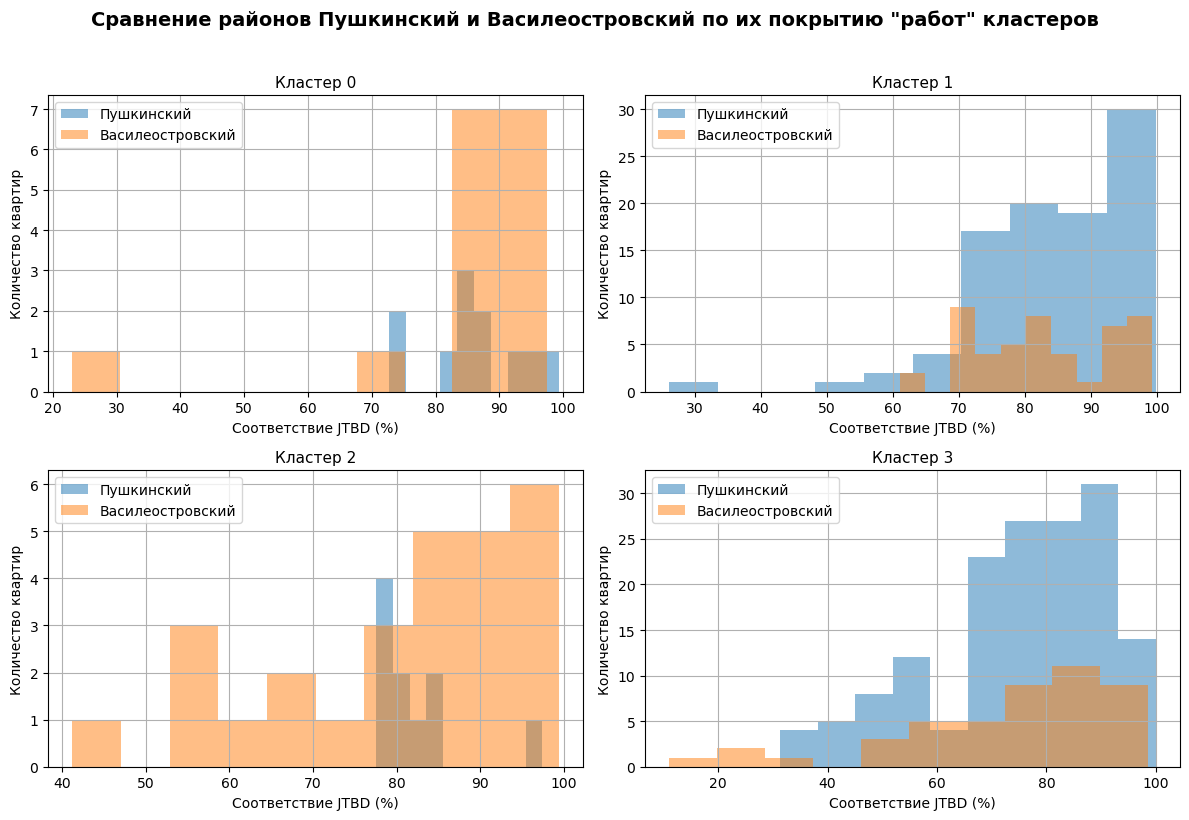

In [64]:
# Сравнение районов по покрытию кластеров

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
clusters = [0, 1, 2, 3]

for idx, cluster in enumerate(clusters):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(df_analysis[(df_analysis['district'] == 'р-н Пушкинский') &
                           (df_analysis['cluster'] == cluster)]['jtbd_score'], 
                           alpha=0.5, label='Пушкинский')
    axes[row, col].hist(df_analysis[(df_analysis['district'] == 'р-н Василеостровский') &
                           (df_analysis['cluster'] == cluster)]['jtbd_score'], 
                           alpha=0.5, label='Василеостровский')
    
    axes[row, col].set_xlabel('Соответствие JTBD (%)', fontsize=10)
    axes[row, col].set_ylabel('Количество квартир', fontsize=10)
    axes[row, col].set_title(f'Кластер {cluster}', fontsize=11)
    axes[row, col].legend()
    axes[row, col].grid()

fig.suptitle('Сравнение районов Пушкинский и Василеостровский по их покрытию "работ" кластеров', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'clusters_compare.png', dpi=300, bbox_inches='tight')
plt.show()

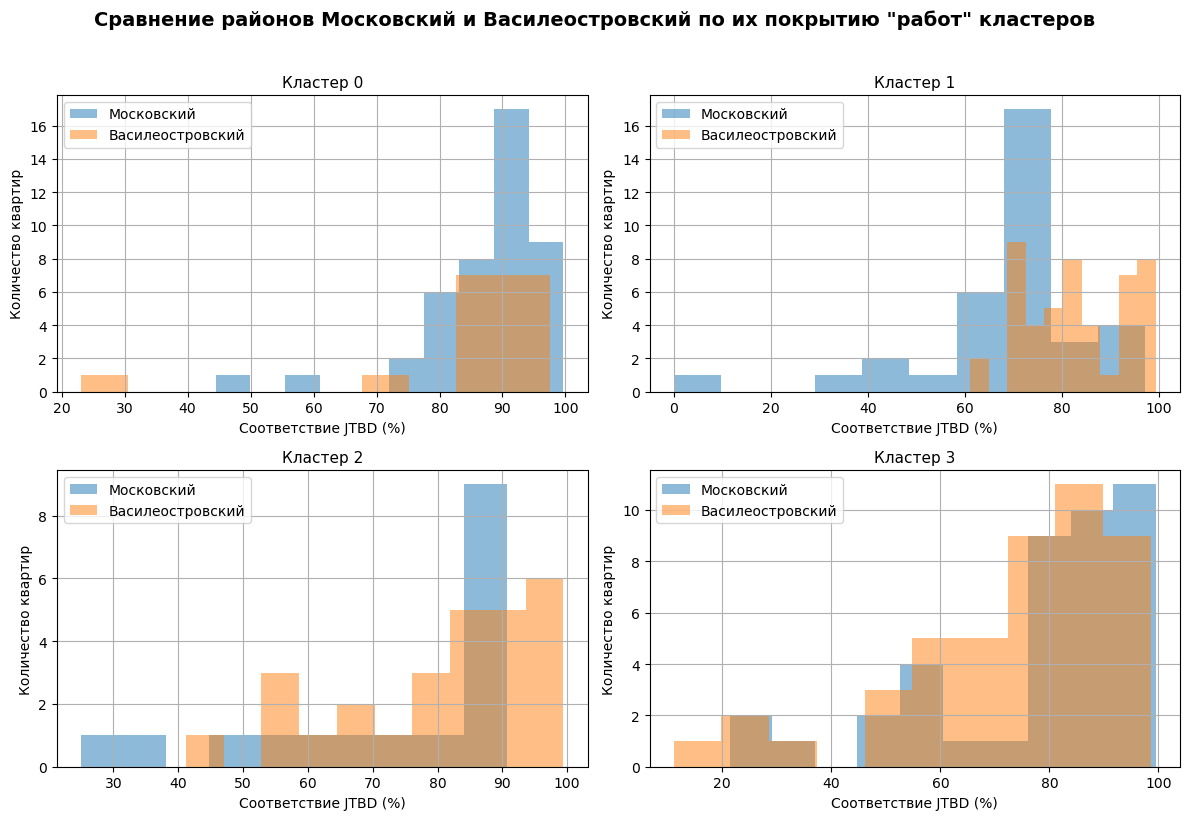

In [65]:
# Сравнение районов по покрытию кластеров
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
clusters = [0, 1, 2, 3]

for idx, cluster in enumerate(clusters):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(df_analysis[(df_analysis['district'] == 'р-н Московский') &
                           (df_analysis['cluster'] == cluster)]['jtbd_score'], 
                           alpha=0.5, label='Московский')
    axes[row, col].hist(df_analysis[(df_analysis['district'] == 'р-н Василеостровский') &
                           (df_analysis['cluster'] == cluster)]['jtbd_score'], 
                           alpha=0.5, label='Василеостровский')
    
    axes[row, col].set_xlabel('Соответствие JTBD (%)', fontsize=10)
    axes[row, col].set_ylabel('Количество квартир', fontsize=10)
    axes[row, col].set_title(f'Кластер {cluster}', fontsize=11)
    axes[row, col].legend()
    axes[row, col].grid()

fig.suptitle('Сравнение районов Московский и Василеостровский по их покрытию "работ" кластеров', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [66]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx

In [69]:
def prepare_cluster_data_as_cause(df, cluster_name):
    # Создаем колонку для кластера во всем датафрейме
    df_modified = df.copy()
    df_modified[f'cluster_{cluster_name}'] = df_modified['cluster'] == cluster_name
    # Отбираем только булевые признаки + метка кластера
    bool_features_names = ['ready', 'is_city', 'popular_developer', 'court', 'entrance', 'parking', 'parks']
    result_columns = bool_features_names + [f'cluster_{cluster_name}']
    result_df = df_modified[result_columns]
    return result_df.astype(bool)

def find_cluster_as_cause_rules(df, cluster_name, min_support=0.1, min_confidence=0.5):
    # Подготавливаем данные
    prepared_data = prepare_cluster_data_as_cause(df, cluster_name)
    # Находим частые наборы признаков
    frequent_itemsets = apriori(
        prepared_data, 
        min_support=min_support, 
        use_colnames=True,
        max_len=3
    )
    # Генерируем правила ассоциации
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=min_confidence
    )
    # Фильтруем только правила, где причина: принадлежность кластеру
    target_column = f'cluster_{cluster_name}'
    cluster_rules = rules[rules['antecedents'].apply(lambda x: target_column in x)]
    # Сортируем по лифту (lift)
    cluster_rules = cluster_rules.sort_values('lift', ascending=False)
    return cluster_rules, frequent_itemsets

for k in range(4):
    cause_rules, cause_itemsets = find_cluster_as_cause_rules(
        df_analysis, 
        k, 
        min_support=0.1, 
        min_confidence=0.5
    )
    
    # Выводим правила
    print(f"Правила, где кластер {k} является причиной:")
    print(f"Найдено правил: {len(cause_rules)}")
    if len(cause_rules) > 0:
        for i, row in cause_rules.iterrows():
            if row['lift'] > 1.3:
                print(f"Если {row['antecedents']} то {row['consequents']}")
                print(f"Достоверность: {row['confidence']:.3f}, Лифт: {row['lift']:.3f}")

Правила, где кластер 0 является причиной:
Найдено правил: 33
Если frozenset({'cluster_0'}) то frozenset({'popular_developer', 'entrance'})
Достоверность: 0.541, Лифт: 2.076
Если frozenset({'cluster_0', 'is_city'}) то frozenset({'popular_developer'})
Достоверность: 0.657, Лифт: 1.827
Если frozenset({'cluster_0', 'parking'}) то frozenset({'popular_developer'})
Достоверность: 0.651, Лифт: 1.811
Если frozenset({'cluster_0', 'entrance'}) то frozenset({'popular_developer'})
Достоверность: 0.644, Лифт: 1.792
Если frozenset({'cluster_0', 'court'}) то frozenset({'popular_developer'})
Достоверность: 0.643, Лифт: 1.789
Если frozenset({'cluster_0'}) то frozenset({'court', 'is_city'})
Достоверность: 0.729, Лифт: 1.742
Если frozenset({'cluster_0'}) то frozenset({'popular_developer'})
Достоверность: 0.602, Лифт: 1.675
Если frozenset({'cluster_0'}) то frozenset({'popular_developer', 'court'})
Достоверность: 0.602, Лифт: 1.675
Если frozenset({'cluster_0'}) то frozenset({'is_city', 'parking'})
Достоверн